<a href="https://colab.research.google.com/github/youkjang/Climate_Chage/blob/main/prj_climate_projection_analysis_tasmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maryland Climate Projection Analysis

##Project Summary
This notebook analyzes projected changes in monthly maximum temperature over Maryland using LOCA CMIP6 climate data. Specifically, it compares two 11-year periods - 2000-2010 (historical) and 2030-2040 (future projection).

##Objectives
- Extract and subset LOCA CMIP6 monthly tasmax data for Maryland (this is done in a different notebook to save computing time issues)
- Compute and plot annual mean for timeseries
- Visualize the difference in average monthly maximum temperature between future and historical periods
- Support climate resilisence planning by identifying warming patterns that may influence public health, infrastructure stress, and energy demand

###Data
- Data: LOCA CMIP6 (GFDL-ESM4), shapefile for MD
- Scenario: [Specify SSP2-4.5 or SSP5-8.5]
- Variable: `tasmax` (monthly maximum temperature)
- Region: Maryland (lat ~32–40, lon ~280–285)


###Reference
- https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/
- shapefile for MD (MDOT SHA County Boundaries data)
: https://data.imap.maryland.gov/


In [1]:
!pip install cartopy --quiet
!pip install us --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 5.8 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import us
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

###Load historical, SSP245, SSP585 data

In [3]:
filename='tasmax.GFDL-CM4.historical.r1i1p1f1.1950-2014.LOCA_16thdeg_v20220413.monthly.n_east.nc'

In [4]:
history = xr.open_dataset(filename)

In [5]:
ssp245 = xr.open_mfdataset('tasmax.GFDL-CM4.ssp245*.nc',combine='by_coords')
ssp585 = xr.open_mfdataset('tasmax.GFDL-CM4.ssp585*.nc',combine='by_coords')

- concat for plotting convinence

In [6]:
ds1 = xr.concat([history, ssp245], dim='time')
ds2 = xr.concat([history, ssp585], dim='time')

In [7]:
gdf = gpd.read_file('MDOT_SHA_County_Boundaries.zip')

In [8]:
# Filter for Region (e.g., Maryland)

lat_range = slice(32, 40)  # Adjust for your region
lon_range = slice(280, 285)

# Select variable
var = 'tasmax_tavg'  # variable name in dataset

- ds_region1 for SSP245
- ds_region2 for SSP585
- ds_region3 for history

In [9]:
ds_region1 = ds1[var].sel(lat=lat_range, lon=lon_range)
ds_region2 = ds2[var].sel(lat=lat_range, lon=lon_range)
ds_region3 = history[var].sel(lat=lat_range, lon=lon_range)

- Convert the coordinates of the county boundaries into the standard latitude and longitude system

In [10]:
gdf = gdf.to_crs("EPSG:4326")

In [11]:
# convert Kelvin to Celsius

if ds_region1.units == 'K':
    ds_region1 = ds_region1 - 273.15
    ds_region1.attrs['units'] = '°C'


if ds_region2.units == 'K':
    ds_region2 = ds_region2 - 273.15
    ds_region2.attrs['units'] = '°C'


if ds_region3.units == 'K':
    ds_region3 = ds_region3 - 273.15
    ds_region3.attrs['units'] = '°C'


###Compute Annual Means

In [19]:
ds_annual1 = ds_region1.resample(time='1YE').mean()
ds_annual2 = ds_region2.resample(time='1YE').mean()
ds_annual3 = ds_region3.resample(time='1YE').mean()

###Plot Annual Time Series

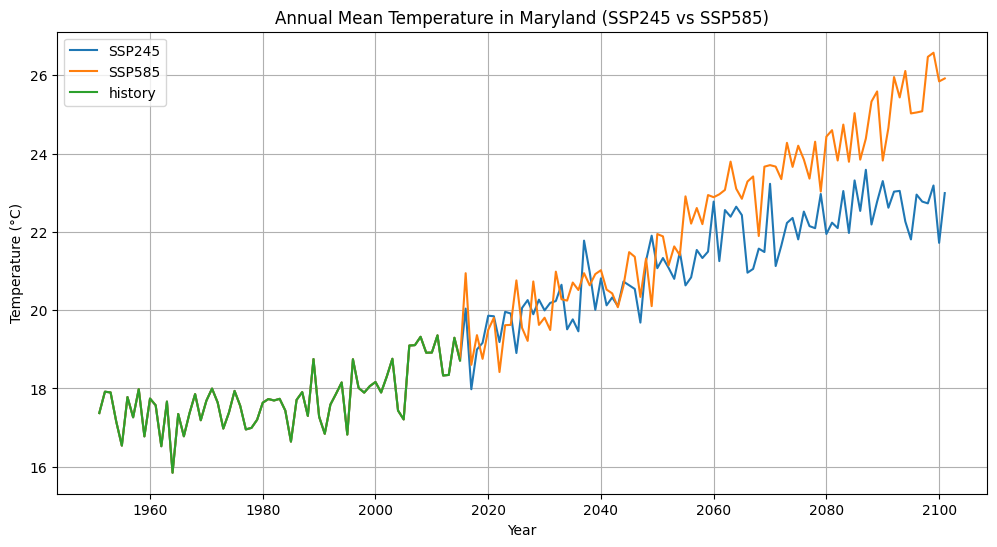

In [13]:

plt.figure(figsize=(12, 6))

# Plot ds_region1,2,3
ds_annual1.mean(dim=['lat', 'lon']).plot(label='SSP245')
ds_annual2.mean(dim=['lat', 'lon']).plot(label='SSP585')
ds_annual3.mean(dim=['lat', 'lon']).plot(label='history')


plt.title('Annual Mean Temperature in Maryland (SSP245 vs SSP585)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.legend()
plt.show()


###Future vs Historical Comparison

In [14]:
#  separate historical and future time ranges
historical1 = ds_region1.sel(time=slice('2000', '2010'))
future1 = ds_region1.sel(time=slice('2040', '2050'))

future2 = ds_region2.sel(time=slice('2040', '2050'))

In [15]:
# Compute mean and visualize
hist_mean = historical1.mean(dim='time')
fut_mean1 = future1.mean(dim='time')
fut_mean2 = future2.mean(dim='time')

###Plot Spatial Map of Change

In [16]:
# Compute difference between history and future simulations
diff1 = fut_mean1 - hist_mean
diff2 = fut_mean2 - hist_mean

###SSP245

Text(0.5, 1.0, 'SSP245 Projected Temperature Change (2000-2010 vs 2040-2050)')

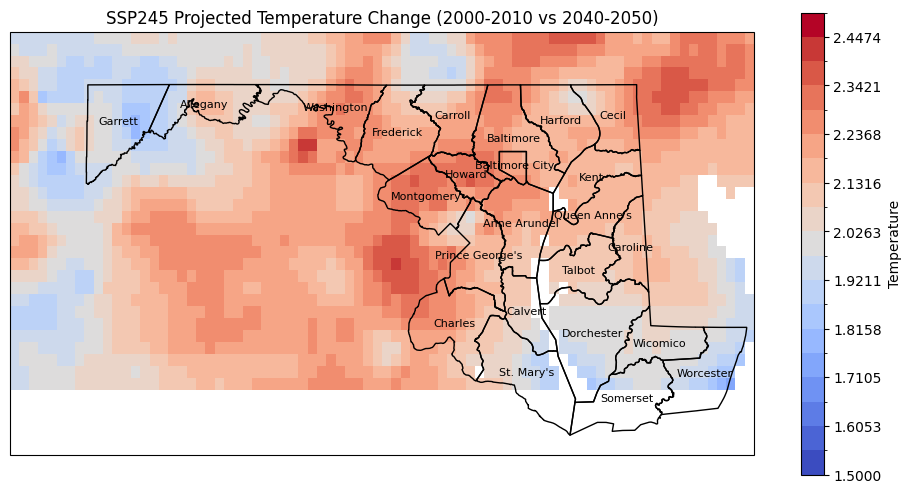

In [20]:
#Set up map (PlateCarree for geographic lat/lon)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

#plot
diff1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=1.5,vmax=2.5, levels=20, cmap='coolwarm', cbar_kwargs={'label': 'Temperature'})

# Plot shapefile on top
gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
# Add text labels from the 'COUNTY' column
for i, row in gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y  # Use centroid for better placement
    name = row['COUNTY']  # Replace 'COUNTY' if your name column is different
    ax.text(x, y, name, fontsize=8, ha='center', va='center') #Center the text

#ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('SSP245 Projected Temperature Change (2000-2010 vs 2040-2050)')

###SSP585

Text(0.5, 1.0, 'SSP585 Projected Temperature Change (2000-2010 vs 2040-2050)')

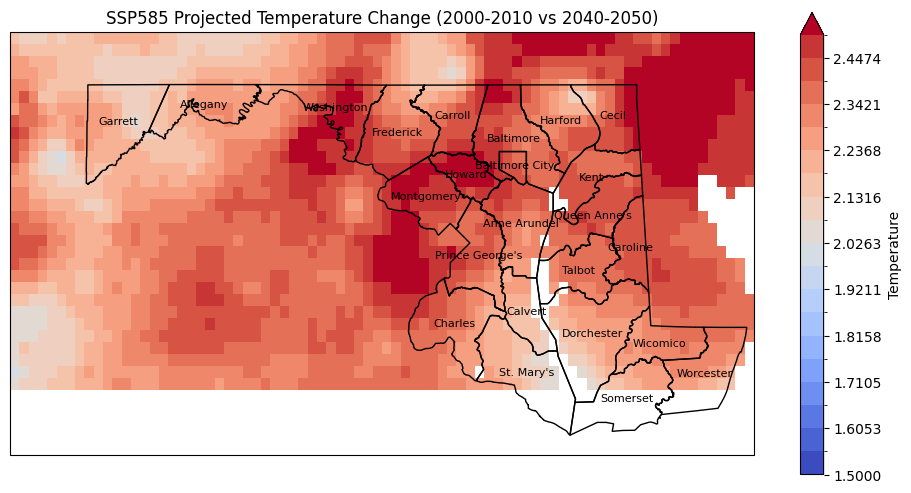

In [18]:
#Set up map (PlateCarree for geographic lat/lon)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

#plot
diff2.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=1.5,vmax=2.5, levels=20, cmap='coolwarm', cbar_kwargs={'label': 'Temperature'})

# Plot shapefile on top
gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
# Add text labels from the 'COUNTY' column (or your name column)
for i, row in gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y  # Use centroid for better placement
    name = row['COUNTY']  # Replace 'COUNTY' if your name column is different
    ax.text(x, y, name, fontsize=8, ha='center', va='center') #Center the text

#ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('SSP585 Projected Temperature Change (2000-2010 vs 2040-2050)')